In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import random
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from keras.layers import Dense, Dropout
from keras.models import Sequential
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.width', 2000)
from keras.optimizers import SGD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

import keras
from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import import_ipynb
from Helpers import *
from PandasFeatureUnion import PandasFeatureUnion

Using TensorFlow backend.


importing Jupyter notebook from Helpers.ipynb
importing Jupyter notebook from PandasFeatureUnion.ipynb


/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')
test_ids = test.index
y_train = np.log(train['SalePrice'])
np.random.seed(1)
random.seed(1)
total_bath= lambda x: x.FullBath+x.HalfBath*0.5 +x.BsmtHalfBath*0.5+x.BsmtFullBath


bath_columns = ['FullBath','HalfBath','BsmtHalfBath', 'BsmtFullBath']
bath_pipeline = Pipeline([
    ('SelectBathColumns',  ColumnSelector(columns=bath_columns)),
    ('fillNaAsZero', FillNA(columns=bath_columns, fill_value=0)),
    ('combine', ApplyTransformer(fn=total_bath, name='Bath')),
  #  ('drop',DropColumns(columns=bath_columns))
]) 
  

important_columns = [
    'GrLivArea', 'MasVnrArea', 'LotArea',  '1stFlrSF',
    
    'YearBuilt','YearRemodAdd',
    
    'OverallQual','MSSubClass',
    'Neighborhood', 'SaleType', 'SaleCondition',
    'BldgType','LotFrontage','GarageCars','CentralAir',
    'PoolQC', 'BsmtQual','ExterQual', 'KitchenQual',
    'MasVnrType', 'HouseStyle'
]
# No improovement
# 'BldgType' 

cs = ColumnSelector(columns=important_columns)

scdt = DummiesTransformer(column='MSSubClass', keys=[ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 150, 160, 180, 190])
oqdt = DummiesTransformer(column='OverallQual', keys=range(1,11))
neigbTrans = DummiesTransformer(column='Neighborhood', keys=["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", "Gilbert", "IDOTRR", "MeadowV", "Mitchel", "Names", "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", "Somerst", "StoneBr", "Timber", "Veenker"])
bdTypeTrans= DummiesTransformer(column='BldgType', keys=['1Fam' ,'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'])
saleTypeTrans= DummiesTransformer(column='SaleType', keys=["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"])
bsmtQualTrans = DummiesTransformer(column='BsmtQual', keys=['Ex','Gd','TA','Fa','Po','None'])
extQualTrans = DummiesTransformer(column='ExterQual', keys=['Ex','Gd','TA','Fa','Po','None'])
kitQualTrans = DummiesTransformer(column='KitchenQual', keys=['Ex','Gd','TA','Fa','Po','None'])
saleCondTrans = DummiesTransformer(column='SaleCondition', keys=['Normal', 'Abnorml',
                                                                'AdjLand','Alloca', 
                                                                 'Family', 'Partial'])
masVnrTypeTrans = DummiesTransformer(column='MasVnrType', keys=['BrkCmn', 'BrkFace', 
                                                                'CBlock','None', 'Stone'])
lotConfigTrans = DummiesTransformer(column='LotConfig', keys=['Inside', 'Corner', 'CulDSac',
                                                             'FR2', 'FR3'])
aircTrans = DummiesTransformer(column='CentralAir', keys=['Y', 'N'])
houseStyleTrans = DummiesTransformer(column='HouseStyle', keys=['1Story','1.5Fin','1.5Unf',
                                                               '2Story','2.5Fin','2.5Unf',
                                                               'SFoyer','SLvl'])

core_pipeline = Pipeline(
    [('SelectColumns', cs),
     ('DummiesMSSubClass', scdt),
     ('OverallQual', oqdt),
     ('DummiesNeighborhood', neigbTrans),
     ('DummiesSaleType', saleTypeTrans),
     ('DummiesBldgType',bdTypeTrans),
     ('fillNaAsZero', FillNA(columns=['LotFrontage','GarageCars','MasVnrArea'], fill_value=0)),
     ('fillNaAsNone', FillNA(columns=['BsmtQual','ExterQual','KitchenQual', 
                                     'SaleCondition','MasVnrType'], fill_value='None')),
     ('LogLotFrontage', ApplyTransformer(fn=lambda x:np.log1p(x.LotFrontage), name='LotFrontage')),
     ('LogGrLivArea', ApplyTransformer(fn=lambda x:np.log1p(x.GrLivArea), name='GrLivArea')),
     ('LogMasVnrArea', ApplyTransformer(fn=lambda x:np.log1p(x.GrLivArea), name='MasVnrArea')),
     ('Log1stFlrSF', ApplyTransformer(fn=lambda x:np.log1p(x['1stFlrSF']), name='1stFlrSF')),
     ('PoolQC_Exists', ApplyTransformer(fn=lambda x:0 if (pd.isnull(x['PoolQC'])) else 1, name='PoolQC')),
     ('BsmtQualTrans', bsmtQualTrans),
     ('ExtQualTrans', extQualTrans),
     ('kitQualTrans', kitQualTrans),
     ('saleCondTrans', saleCondTrans),
      ('houseStyletrans', houseStyleTrans),
     ('masVnrTypeTrans',masVnrTypeTrans),
     ('aircTrans', aircTrans)
    ])

pp = PandasFeatureUnion([
    ('bath',bath_pipeline),
    ('core', core_pipeline)], n_jobs=None)

X_train = pp.fit_transform(train)
X_test = pp.transform(test)
 
 

/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [3]:
# define model
# cc=keras.constraints.MinMaxNorm(min_value=0.0, max_value=2.0, rate=1, axis=0)
model = Sequential()
input_layer = Dense(20, 
#                     kernel_constraint=cc,
#                     kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#                     bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                    input_dim=len(X_train.columns), 
                    activation='relu', 
                    kernel_initializer='normal') 
model.add(input_layer)
model.add(Dropout(rate=0.1))

model.add(Dense(50, activation='relu', kernel_initializer='normal') )
model.add(Dense(25, activation='relu', kernel_initializer='normal') )
model.add(Dense(10, activation='relu', kernel_initializer='normal') )
model.add(Dense(1, activation='linear'))

optimizer = keras.optimizers.SGD(lr=0.001) #Adam(lr=0.0015);
# compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 01489: early stopping
Train Error: 0.124, Test Error: 0.160


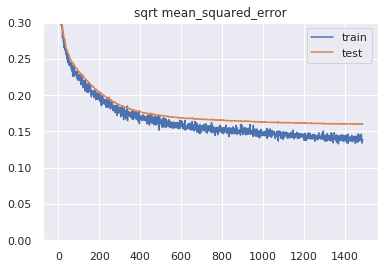

In [4]:

trainX, testX, trainy, testy = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=1)

trainX_ids = trainX.index
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
testData = X_test
X_test=scaler.transform(X_test)
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                                           patience=100, verbose=1, mode='auto', 
                                           baseline=None, restore_best_weights=True)
tb_callback =keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, 
                                         batch_size=32, write_graph=True, 
                                         write_grads=True, write_images=True,
                                         embeddings_freq=0, embeddings_layer_names=None,
                                         embeddings_metadata=None, embeddings_data=None,
                                         update_freq='epoch')
history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                    epochs=4000, verbose=0, batch_size=32, callbacks=[early_stop, tb_callback])

drawTFModel(history, model, trainX, trainy, testX, testy)

In [5]:
result = model.predict(X_test)
dfR = pd.DataFrame(test_ids,columns=['Id'])
dfR['SalePrice']=np.exp(result)
dfR.to_csv('predictions.csv',index = None, header=True)

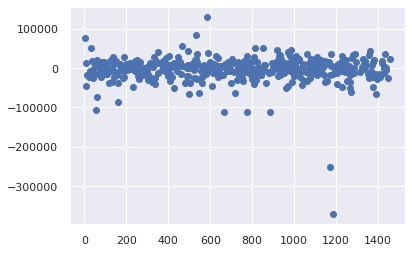

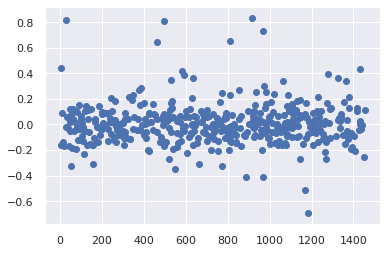

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
427,80,RL,NaN,12800,Pave,NaN,Reg,Low,AllPub,Inside,Mod,SawyerW,Norm,Norm,1Fam,SLvl,7,5,1989,1989,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,145.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1518,Unf,0,0,1518,GasA,Gd,Y,SBrkr,1644,0,0,1644,1,1,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1989.0,Fin,2,569,TA,TA,Y,80,0,0,0,396,0,NaN,NaN,NaN,0,8,2009,WD,Normal,275000
376,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,0,0,1,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000
54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
1023,50,RM,52.0,9439,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,5,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,LwQ,324,Unf,0,588,912,GasA,Gd,Y,FuseA,912,336,0,1248,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,1,160,Fa,Fa,Y,0,0,192,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,87000
1271,40,RL,NaN,23595,Pave,NaN,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,1979,1979,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1258,Unf,0,74,1332,GasA,TA,Y,SBrkr,1332,192,0,1524,2,0,0,1,0,1,Gd,4,Typ,1,TA,Attchd,1979.0,Fin,2,586,TA,TA,Y,268,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,260000
810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2.5Unf,5,5,1898,1965,Hip,CompShg,AsbShng,AsbShng,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,849,849,GasA,TA,N,FuseA,1075,1063,0,2138,0,0,2,0,2,3,TA,11,Typ,0,NaN,Detchd,1910.0,Unf,2,360,Fa,Po,N,40,156,0,0,0,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000
1449,50,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,2Story,4,7,1910,2000,Gable,CompShg,MetalSd,HdBoard,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,560,560,GasA,Gd,N,SBrkr,796,550,0,1346,0,0,1,1,2,1,TA,6,Min2,0,NaN,Detchd,1950.0,Unf,1,384,Fa,TA,Y,168,24,0,0,0,0,NaN,GdWo,NaN,0,5,2007,WD,Normal,112000
983,20,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,1Fam,1Story,7,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,16.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1266,1266,GasA,Ex,Y,SBrkr,1266,0,0,1266,0,0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2007.0,Fin,2,388,TA,TA,Y,100,16,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,159895
853,75,RL,53.0,7128,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2.5Unf,7,5,1941,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,364,Unf,0,554,918,GasA,Gd,Y,SBrkr,918,728,0,1646,0,0,2,0,4,1,TA,7,Typ,2,Gd,Detchd,1941.0,Unf,1,240,TA,TA,Y,0,0,0,0,126,0,NaN,MnPrv,NaN,0,8,2007,WD,Normal,164000


In [6]:
tt = pd.DataFrame(testy.copy())
trainedPrice = model.predict(testX)
tt['PredictedLog'] = trainedPrice
tt['Predicted']=np.exp(trainedPrice)
tt['Real']=np.exp(testy)
tt['Delta'] = tt.Predicted - tt.Real
tt['DeltaLog'] =tt.PredictedLog - tt.SalePrice
plt.scatter(tt.index, tt.Delta)
plt.show()
plt.scatter(tt.index, tt.DeltaLog)
 
plt.show()


problematicIDs = tt[np.abs(tt.DeltaLog) >0.2]


train.loc[problematicIDs.index, :]


In [7]:
tt.describe()

,SalePrice,PredictedLog,Predicted,Real,Delta,DeltaLog
count,438.000000,438.000000,438.000000,438.000000,438.000000,438.000000
mean,12.004013,12.009353,176042.781250,179714.073059,-3671.306275,0.005341
std,0.435226,0.367058,69011.804688,84596.939592,32622.747902,0.160278
min,10.460242,11.164452,70576.437500,34900.000000,-371282.687500,-0.689885
25%,11.746013,11.741105,125631.058594,126250.000000,-13971.314453,-0.082339
50%,12.001199,11.985468,160412.257812,162950.000000,-758.191406,-0.005522
75%,12.254863,12.244688,207874.175781,210000.000000,11406.875000,0.068215
max,13.521139,13.032725,457131.031250,745000.000000,130606.906250,0.831080


In [8]:
df=train

In [9]:
#!rm -rf logs

In [10]:
pd.DataFrame(X_test, columns=testData.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
FullBath,1459.0,0.523646,0.185063,0.000000,0.333333,0.666667,0.666667,1.333333
HalfBath,1459.0,0.188828,0.251508,0.000000,0.000000,0.000000,0.500000,1.000000
BsmtHalfBath,1459.0,0.032557,0.126153,0.000000,0.000000,0.000000,0.000000,1.000000
BsmtFullBath,1459.0,0.144620,0.176842,0.000000,0.000000,0.000000,0.333333,1.000000
Bath,1459.0,0.245236,0.166367,0.000000,0.100000,0.200000,0.400000,1.200000
GrLivArea,1459.0,0.510034,0.111867,0.069807,0.426911,0.514651,0.579705,0.963896
MasVnrArea,1459.0,0.550930,0.110531,0.082253,0.469837,0.557596,0.620982,0.969328
LotArea,1459.0,0.039819,0.023163,0.000795,0.028470,0.037856,0.047758,0.258478
1stFlrSF,1459.0,0.449213,0.124197,0.074682,0.363497,0.443455,0.537274,1.031210
YearBuilt,1459.0,0.719984,0.220218,0.050725,0.586957,0.731884,0.934783,1.000000


In [11]:
test_ids

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [12]:
testData.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [13]:
testData.loc[2577,:]

FullBath                    2.000000
HalfBath                    0.000000
BsmtHalfBath                0.000000
BsmtFullBath                0.000000
Bath                        2.000000
GrLivArea                   7.511525
MasVnrArea                  2.141421
LotArea                  9060.000000
1stFlrSF                    6.849066
YearBuilt                1923.000000
YearRemodAdd             1999.000000
LotFrontage                 3.931826
GarageCars                  0.000000
PoolQC                      0.000000
MSSubClass_20               0.000000
MSSubClass_30               0.000000
MSSubClass_40               0.000000
MSSubClass_45               0.000000
MSSubClass_50               0.000000
MSSubClass_60               0.000000
MSSubClass_70               1.000000
MSSubClass_75               0.000000
MSSubClass_80               0.000000
MSSubClass_85               0.000000
MSSubClass_90               0.000000
MSSubClass_120              0.000000
MSSubClass_150              0.000000
M

In [14]:
n=lambda x: (1 if (pd.isnull(x)) else 0)

In [15]:
n(np.nan)

1

In [16]:
n(55)

0

In [35]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors] )
    ax.grid(linestyle='-', linewidth='0.5', color='red')
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [36]:
n(None)

1

In [37]:
pd.isnull('sss')

False

In [38]:
d1 = X_train.copy()
d1['SalePrice'] = y_train

In [39]:
import time
time_start = time.time()
tsne = TSNE(random_state=1, n_components=2, perplexity=2500).fit_transform(d1)
print( 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 31.26824140548706 seconds


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1460 but corresponding boolean dimension is 1

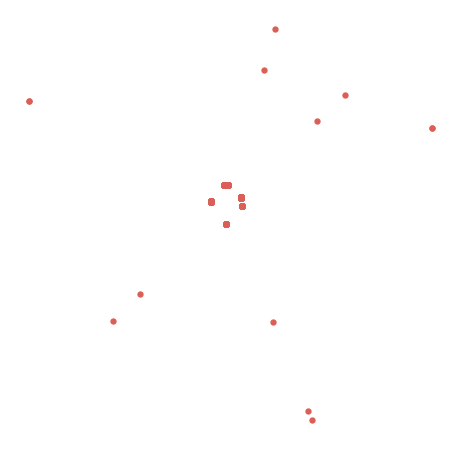

In [40]:
 fashion_scatter(tsne, pd.Series([0]))

In [ ]:
tsne[0]

In [ ]:
len(tsne)